In [3]:
# !pip install wordcloud

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords,wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
import re
import string
import matplotlib.pyplot as plt
import time 
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Giridhar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Giridhar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [101]:
df = pd.read_csv(r"C:\Users\Giridhar\OneDrive\Documents\question\train.csv")
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


### Preprocessing

In [102]:
df.question1= df.question1.fillna('')

In [103]:
df.question2.isna().sum()

2

In [104]:
df.question2= df.question2.fillna('')

#### Converting to lower case

In [106]:
df['question1'] = df['question1'].apply(lambda x: x.lower() )
df['question2'] = df['question2'].apply(lambda x: x.lower() )

#### Removing html tags

In [107]:
df['question1'] = df['question1'].apply(lambda x: re.compile(r'<[^>]+>').sub('',x))
df['question2'] = df['question2'].apply(lambda x: re.compile(r'<[^>]+>').sub('',x))

In [108]:
def punctuation(x):
  a = x.maketrans(' ',' ',string.punctuation)
  a1 = x.translate(a)

  return a1

#### Removing punctuations

In [109]:
df['question1'] = df['question1'].apply(lambda x: punctuation(x) )
df['question2'] = df['question2'].apply(lambda x: punctuation(x) )

#### Removing numbers

In [110]:
df['question1'] = df['question1'].apply(lambda x: re.sub(r'\d+','',x))
df['question2'] = df['question2'].apply(lambda x: re.sub(r'\d+','',x))

#### Removing html links

In [111]:
df['question1'] = df['question1'].apply(lambda x: re.sub(r'https?:\/\/.*[\r\n]*','',x))
df['question2'] = df['question2'].apply(lambda x: re.sub(r'https?:\/\/.*[\r\n]*','',x))

In [112]:
stopwords = set(stopwords.words('english'))

#### Removing stopwords

In [113]:
df['question1'] = df['question1'].apply(lambda x: ' '.join([s for s in x.split() if s not in stopwords]))
df['question2'] = df['question2'].apply(lambda x: ' '.join([s for s in x.split() if s not in stopwords]))

#### Lemmatization

In [114]:
lemmatizer = WordNetLemmatizer()
df['question1'] = df['question1'].apply(lambda x: lemmatizer.lemmatize(x))
df['question2'] = df['question2'].apply(lambda x: lemmatizer.lemmatize(x))

In [115]:
def cosine(row,row1):
  word1 = row.split()
  word2 = row1.split()

  word1 = {s for s in word1 if not s in stopwords }
  word2 = {s for s in word2 if not s in stopwords }

  u = word1.union(word2)
  l1=[]
  l2=[]
  for w in u:
    if w in word1:
      l1.append(1)
    else:
      l1.append(0)

    if w in word2:
      l2.append(1)
    else:
      l2.append(0)

  l1=np.asarray(l1)
  l2=np.asarray(l2)

  num = np.dot(l1,l2.T)

  # sum1=0
  # sum2=0
  # for i in l1:
  #   sum1+=i*i
  # for j in l2:
  #   sum2+=j*j

  den = np.sqrt(np.sum(np.square(l1))) + np.sqrt(np.sum(np.square(l2)))

  cos = num/den

  return cos


  


#### Creating cosine feature

In [116]:
df['cosine'] = df.apply(lambda x: cosine(x['question1'],x['question2']),axis=1)

<ipython-input-115-adfab47f55f4>:36: RuntimeWarning: invalid value encountered in double_scalars
  cos = num/den


#### Wordcloud for q1 and q2

(-0.5, 399.5, 199.5, -0.5)

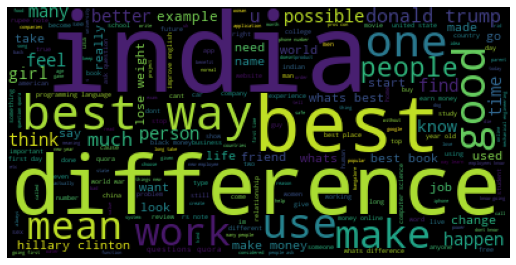

In [117]:
from wordcloud import WordCloud
q1 = df['question1'].str.cat(sep=' ')

wordcloud = WordCloud().generate(str(q1))

plt.figure(figsize=(9,9))
plt.imshow(wordcloud)
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

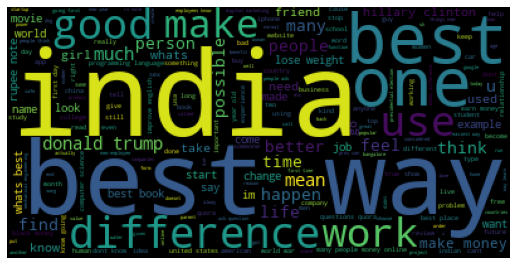

In [118]:
q2 = df['question2'].str.cat(sep=' ')

wordcloud1 = WordCloud().generate(str(q2))

plt.figure(figsize=(9,9))
plt.imshow(wordcloud1)
plt.axis("off")

#### Splitting the words

In [85]:
df['question1'] = df['question1'].apply(lambda x: x.split())
df['question2'] = df['question2'].apply(lambda x: x.split())

In [23]:
# cosine(df.question1[6],df.question2[6])

In [24]:
A = df[df.is_duplicate==1]
A.head()

,id,qid1,qid2,question1,question2,is_duplicate,cosine
5,5,11,12,"[astrology, capricorn, sun, cap, moon, cap, ri...","[im, triple, capricorn, sun, moon, ascendant, ...",1,0.755929
7,7,15,16,"[good, geologist]","[great, geologist]",1,0.353553
11,11,23,24,"[read, find, youtube, comments]","[see, youtube, comments]",1,0.535898
12,12,25,26,"[make, physics, easy, learn]","[make, physics, easy, learn]",1,1.000000
13,13,27,28,"[first, sexual, experience, like]","[first, sexual, experience]",1,0.803848


In [25]:
# cosine(df.question1[12],df.question2[12])

In [26]:
df.question1[8]

['use', 'シ', 'instead', 'し']

In [27]:
# import gzip
# with open(r"C:\Users\Giridhar\Downloads\GoogleNews-vectors-negative300.bin.gz","rb") as f:
#     file = f.read()

# f.close()
# file
!pip install gensim

In [28]:
from gensim.models import KeyedVectors,Word2Vec

file = r"C:\Users\Giridhar\Downloads\GoogleNews-vectors-negative300.bin"



In [29]:
S1 = df['question1'].values
S2 = df['question2'].values

In [30]:
S1

array([list(['step', 'step', 'guide', 'invest', 'share', 'market', 'india']),
       list(['story', 'kohinoor', 'kohinoor', 'diamond']),
       list(['increase', 'speed', 'internet', 'connection', 'using', 'vpn']),
       ..., list(['one', 'coin']),
       list(['approx', 'annual', 'cost', 'living', 'studying', 'uic', 'chicago', 'indian', 'student']),
       list(['like', 'sex', 'cousin'])], dtype=object)

In [31]:
S = np.concatenate((S1,S2))
S.shape

(808580,)

#### Converting word to vector

In [32]:
model = Word2Vec(S,size=100,min_count=1,window=5)

TypeError: __init__() got an unexpected keyword argument 'size'

In [ ]:
def average_vectors(m,a):

  text = []

  for b in a:
    if b in m.wv.vocab:
      text.append(b)

  if(len(text)>0):
    k = np.mean(m[text],axis=0)
  else:
    k=[]

  return k

#### Finding average of word vectors in a sentence

In [ ]:
df['question1'] = df['question1'].apply(lambda x: average_vectors(model,x))
df['question2'] = df['question2'].apply(lambda x: average_vectors(model,x))

In [ ]:
df.head()


In [ ]:
# new_df = pd.DataFrame(vec1)
# new_df.head()

In [ ]:
# vector = TfidfVectorizer(analyzer="word",token_pattern=r'\w{1,}',max_features=5000)

# vector.fit(pd.concat((df['question1'],df['question2'])).unique())



In [ ]:
# df.drop()

In [ ]:
# v1 = vector.transform(df['question1'].values)
# v2 = vector.transform(df['question2'].values)

In [ ]:
# type(v2)
q1 = df['question1'].values
q2 = df['question2'].values


q3 = []
q4 = []
for w in q1:
  q3.append(w)

for w in q2:
  q4.append(w)

len(q3)

In [ ]:
n_df = pd.DataFrame(q3)
n1_df = pd.DataFrame(q4)
map={}
for i in range(100):
  map[i] = i+100
n1_df.rename(columns=map,inplace=True)
n2_df = pd.concat((n_df,n1_df),axis=1)
n2_df.head()

In [ ]:
print(n2_df.shape,df.shape)
n2_df.isnull().sum()

In [ ]:
df1 = pd.concat((df,n2_df),axis=1)

In [6]:
df1 = pd.read_csv(r"C:\Users\Giridhar\Downloads\preprocessed_data.csv")
df1.head()

,id,qid1,qid2,question1,question2,is_duplicate,cosine,0,1,2,...,190,191,192,193,194,195,196,197,198,199
0,0,1,2,[-0.14900519 -1.0112225 -0.2295518 0.084975...,[-1.72718838e-01 -1.03470314e+00 -2.31782183e-...,0,1.067109,-0.149005,-1.011222,-0.229552,...,1.141118,-0.830518,0.121669,-0.593407,-0.392769,0.432755,-0.291232,0.382448,0.046789,0.129575
1,1,3,4,[-4.58844118e-02 3.75664413e-01 5.48557818e-...,[-4.5651901e-01 -5.3546107e-01 -3.9446764e-02 ...,0,0.438551,-0.045884,0.375664,0.548558,...,0.154553,-0.229827,-0.453176,-0.572880,-0.244704,0.177935,0.424619,0.095711,0.221727,0.044111
2,2,5,6,[ 0.585929 -1.3218106 0.6702852 -0.067880...,[ 0.5547544 -1.0046527 0.29370707 0.249198...,0,0.426844,0.585929,-1.321811,0.670285,...,0.058781,-0.976184,0.783265,0.216488,-1.367985,-0.257401,0.073853,1.015363,0.016711,-0.872436
3,3,7,8,[ 1.36240438e-01 -8.60011876e-01 1.54244334e-...,[-0.81315243 -0.8052504 0.50273097 -0.811857...,0,0.000000,0.136240,-0.860012,0.154244,...,0.184334,-0.567007,-0.867604,-0.275443,-0.195009,0.047383,0.176439,-0.064248,-0.734166,0.754712
4,4,9,10,[ 0.3941738 -0.12497417 0.32080725 -0.258820...,[ 0.70324385 0.02808632 0.4789731 -0.364138...,0,0.370484,0.394174,-0.124974,0.320807,...,-0.950539,-0.961368,-0.360564,-0.096898,-1.259921,0.187396,-0.310276,0.059424,-0.481708,0.457574


In [7]:
# from sklearn.metrics.pairwise import cosine_similarity
import scipy

# cos = cosine_similarity(v1,v2)

# cos
# X = scipy.sparse.hstack((v1,v2))
# dfv1 = pd.DataFrame(nv1)
# dfv1.head()
X = df1.drop(['id','qid1','qid2','is_duplicate'],axis=1)
df2 = df1.drop(['id','question1','question2'],axis=1)


In [8]:
df2.duplicated().sum()

0

In [9]:
# df['cosine'] = df.apply(lambda x: cosine(x['question1'],x['question2']),axis=1) 
X.drop(['question1','question2'],axis=1,inplace=True)

In [10]:
X.head()

,cosine,0,1,2,3,4,5,6,7,8,...,190,191,192,193,194,195,196,197,198,199
0,1.067109,-0.149005,-1.011222,-0.229552,0.084975,-0.141221,0.010668,-0.339875,0.722678,-0.433558,...,1.141118,-0.830518,0.121669,-0.593407,-0.392769,0.432755,-0.291232,0.382448,0.046789,0.129575
1,0.438551,-0.045884,0.375664,0.548558,0.468324,0.423710,0.099683,0.249299,-0.264702,-0.437453,...,0.154553,-0.229827,-0.453176,-0.572880,-0.244704,0.177935,0.424619,0.095711,0.221727,0.044111
2,0.426844,0.585929,-1.321811,0.670285,-0.067881,0.215138,0.193502,-0.170210,0.611217,-0.583628,...,0.058781,-0.976184,0.783265,0.216488,-1.367985,-0.257401,0.073853,1.015363,0.016711,-0.872436
3,0.000000,0.136240,-0.860012,0.154244,0.617138,-0.335602,0.425840,-0.090390,0.426955,-0.317168,...,0.184334,-0.567007,-0.867604,-0.275443,-0.195009,0.047383,0.176439,-0.064248,-0.734166,0.754712
4,0.370484,0.394174,-0.124974,0.320807,-0.258820,0.472775,0.688309,-0.396882,-0.984049,0.159109,...,-0.950539,-0.961368,-0.360564,-0.096898,-1.259921,0.187396,-0.310276,0.059424,-0.481708,0.457574


In [11]:
# df.drop(['id','qid1','qid2','question1','question2'],axis=1,inplace=True)
X.fillna(0,inplace=True)

In [12]:
X.isnull().sum()

cosine    0
0         0
1         0
2         0
3         0
         ..
195       0
196       0
197       0
198       0
199       0
Length: 201, dtype: int64

In [13]:
# X=df.cosine
Y=df1.is_duplicate

In [14]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
X = StandardScaler().fit_transform(X)
X = MinMaxScaler().fit_transform(X)

In [15]:
from sklearn.decomposition import PCA
p = PCA(2)
reduced = p.fit_transform(X)

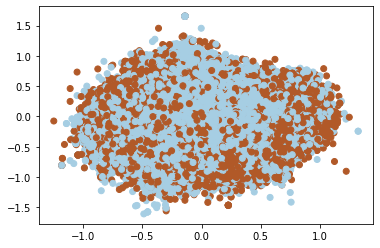

In [16]:
plt.scatter(reduced[:,0],reduced[:,1],c=Y,cmap='Paired')

In [17]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,train_size=0.7,random_state=0)

In [18]:
X_train.shape

(283003, 201)

In [19]:
xtrain1 = p.fit_transform(X_train)
xtest1 = p.fit_transform(X_test)

In [20]:
from sklearn.metrics import accuracy_score,log_loss

In [114]:
def plot_dec_boundary(c,x):
    plt.figure(figsize=(10,10))
    # positive_label = reduc[Y==1]
    # negative_label = reduc[Y==-1]
    # plt.scatter(positive_label[:,0],positive_label[:,1],label="1",s=20)
    # plt.scatter(negative_label[:,0],negative_label[:,1],label="-1",s=20)
    plt.scatter(x[:,0],x[:,1],c=Y_train,s=20,cmap="Paired")
    plt.legend()
    ax = plt.gca()

    x1 = ax.get_xlim()
    y2 = ax.get_ylim()

    x3 = np.linspace(x1[0], x1[1], 50)
    y3 = np.linspace(y2[0], y2[1], 50)
    x4,y4 = np.meshgrid(x3,y3)
    new_arr = np.vstack([x4.ravel(),y4.ravel()]).T
#     print(new_arr.shape)
    out = c.decision_function(new_arr).reshape(x4.shape)

    ax.contour(
        x4, y4, out, colors="k", levels = [0,1], alpha=0.5, linestyles = ["-","--"]
    )


    plt.show()

In [117]:
def plot_dec_boundary_svc(c,x):
    plt.figure(figsize=(10,10))
    # positive_label = reduc[Y==1]
    # negative_label = reduc[Y==-1]
    # plt.scatter(positive_label[:,0],positive_label[:,1],label="1",s=20)
    # plt.scatter(negative_label[:,0],negative_label[:,1],label="-1",s=20)
    plt.scatter(x[:,0],x[:,1],c=Y_train,s=20,cmap="Paired")
    plt.legend()
    ax = plt.gca()

    x1 = ax.get_xlim()
    y2 = ax.get_ylim()

    x3 = np.linspace(x1[0], x1[1], 50)
    y3 = np.linspace(y2[0], y2[1], 50)
    x4,y4 = np.meshgrid(x3,y3)
    new_arr = np.vstack([x4.ravel(),y4.ravel()]).T
#     print(new_arr.shape)
    out = c.decision_function(new_arr).reshape(x4.shape)

    ax.contour(
        x4, y4, out, colors="k", levels = [-1,0,1], alpha=0.5, linestyles = ["--","-","--"]
    )


    plt.show()

### Decision tree

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,log_loss

clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train,Y_train)



DecisionTreeClassifier(random_state=0)

In [72]:
import joblib
# joblib.dump(clf,"dt")
clf11 = joblib.load('dt')

In [73]:
pred_train = clf11.predict(X_train)
pred = clf11.predict(X_test)

print("training accuracy :",accuracy_score(Y_train,pred_train))
print("testing accuracy :",accuracy_score(Y_test,pred))

training accuracy : 0.9971272389338629
testing accuracy : 0.7423796449743171


In [74]:
pred_train_prob = clf11.predict_proba(X_train)
pred_prob = clf11.predict_proba(X_test)
print("log loss of train set : ",log_loss(Y_train,pred_train_prob))
print("log loss of test set : ",log_loss(Y_test,pred_prob))

log loss of train set :  0.004746707852126468
log loss of test set :  8.819706624111653


In [75]:
print(classification_report(Y_train,pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    178667
           1       1.00      0.99      1.00    104336

    accuracy                           1.00    283003
   macro avg       1.00      1.00      1.00    283003
weighted avg       1.00      1.00      1.00    283003



In [76]:
print(classification_report(Y_test,pred))

              precision    recall  f1-score   support

           0       0.80      0.79      0.79     76360
           1       0.65      0.66      0.66     44927

    accuracy                           0.74    121287
   macro avg       0.72      0.73      0.72    121287
weighted avg       0.74      0.74      0.74    121287



In [21]:
path = clf11.cost_complexity_pruning_path(X_train, Y_train)
ccp_alphas,impurities = path.ccp_alphas,path.impurities

In [22]:
ccp_alphas.shape

(17032,)

In [126]:
import time
from sklearn.tree import DecisionTreeClassifier
dts = []
for ccp in ccp_alphas[11100:16100:1000]:
  start = time.time()
  clf1 = DecisionTreeClassifier(random_state=0,ccp_alpha=ccp)
  clf1.fit(X_train,Y_train)
  dts.append(clf1)
  print(time.time()-start)

211.08260297775269
204.96210312843323
202.56663131713867
206.49480438232422
213.66697907447815


In [24]:
import joblib
# joblib.dump(dts,"dts")
dts = joblib.load('dts')

In [25]:
train_acc = [accuracy_score(Y_train,clf2.predict(X_train)) for clf2 in dts]
test_acc = [accuracy_score(Y_test,clf2.predict(X_test)) for clf2 in dts]
train_acc_prob = [log_loss(Y_train,clf2.predict_proba(X_train)) for clf2 in dts]
test_acc_prob = [log_loss(Y_test,clf2.predict_proba(X_test)) for clf2 in dts]

In [26]:
print(train_acc)
print(test_acc)
print(train_acc_prob)
print(test_acc_prob)

[0.9266050183213606, 0.9107182609371632, 0.8928103235654745, 0.8696868937785112, 0.8368603866390109]
[0.7511769604326927, 0.751366593286997, 0.7515809608614279, 0.7515232465144657, 0.7521663492377584]
[0.2238942380769095, 0.25612644256068806, 0.2901735884077679, 0.3287210426190044, 0.37430677854956973]
[1.883645873945761, 1.5129034164938786, 1.176170261590895, 0.857297577015019, 0.6172546810370986]


Text(0, 0.5, 'accuracy')

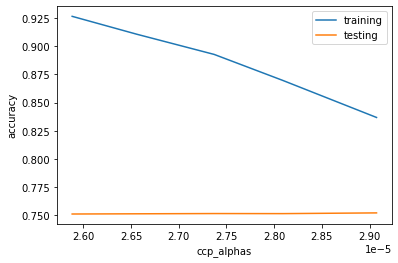

In [28]:
plt.plot(ccp_alphas[15500:16000:100],train_acc,label="training")
plt.plot(ccp_alphas[15500:16000:100],test_acc,label="testing")
plt.legend()
plt.xlabel('ccp_alphas')
plt.ylabel('accuracy')

Text(0, 0.5, 'logloss')

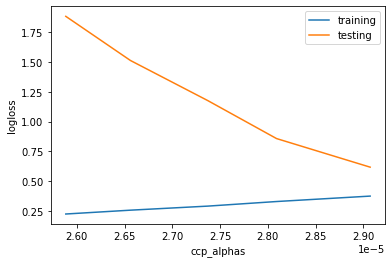

In [29]:
plt.plot(ccp_alphas[15500:16000:100],train_acc_prob,label="training")
plt.plot(ccp_alphas[15500:16000:100],test_acc_prob,label="testing")
plt.legend()
plt.xlabel('ccp_alphas')
plt.ylabel('logloss')

In [246]:
dec_tree = pd.DataFrame()
dec_tree['ccp_alpha'] = ccp_alphas[15500:16000:100]
dec_tree['train accuracy'] = train_acc
dec_tree['test accuracy'] = test_acc
dec_tree['train log loss'] = train_acc_prob
dec_tree['test log loss'] = test_acc_prob
dec_tree

NameError: name 'ccp_alphas' is not defined

In [17]:
# joblib.dump(clf,'dt1')
clf = joblib.load('dt1')

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,log_loss

# clf = DecisionTreeClassifier(random_state=0,ccp_alpha=ccp_alphas[15500:16000:100][4])
clf.fit(X_train,Y_train)

pred_train = clf.predict(X_train)
pred = clf.predict(X_test)

print("training accuracy : ",accuracy_score(Y_train,pred_train))
print("testing accuracy : ",accuracy_score(Y_test,pred))

pred_train_prob = clf.predict_proba(X_train)
pred_prob = clf.predict_proba(X_test)
print("log loss of train set : ",log_loss(Y_train,pred_train_prob))
print("log loss of test set : ",log_loss(Y_test,pred_prob))

training accuracy :  0.8043624979240502
testing accuracy :  0.7519767163834541
log loss of train set :  0.41331015064896054
log loss of test set :  0.5193260322835174


In [19]:
print(classification_report(Y_train,pred_train))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85    178667
           1       0.75      0.71      0.73    104336

    accuracy                           0.80    283003
   macro avg       0.79      0.79      0.79    283003
weighted avg       0.80      0.80      0.80    283003



In [20]:
print(classification_report(Y_test,pred))

              precision    recall  f1-score   support

           0       0.80      0.81      0.81     76360
           1       0.67      0.65      0.66     44927

    accuracy                           0.75    121287
   macro avg       0.73      0.73      0.73    121287
weighted avg       0.75      0.75      0.75    121287



### XGBOOST

In [216]:
import joblib
# joblib.dump(clf1,'xg')
clf1 = joblib.load('xg')

In [217]:
# !pip install xgboost
from xgboost import XGBClassifier

# clf1 = XGBClassifier(max_depth=10, n_estimators=80,use_label_encoder=False)
# clf1.fit(X_train,Y_train)

pred_train1 = clf1.predict(X_train)
pred1 = clf1.predict(X_test)



In [218]:
print("training accuracy : ",accuracy_score(Y_train,pred_train1))
print("testing accuracy : ",accuracy_score(Y_test,pred1))
pred_train_prob6 = clf1.predict_proba(X_train)
pred_prob6 = clf1.predict_proba(X_test)
print("log loss of train set : ",log_loss(Y_train,pred_train_prob6))
print("log loss of test set : ",log_loss(Y_test,pred_prob6))

training accuracy :  0.9496613110108374
testing accuracy :  0.8059561206064954
log loss of train set :  0.19343931670330922
log loss of test set :  0.3922029939354208


In [166]:
print(classification_report(Y_train,pred_train1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    178667
           1       1.00      1.00      1.00    104336

    accuracy                           1.00    283003
   macro avg       1.00      1.00      1.00    283003
weighted avg       1.00      1.00      1.00    283003



In [167]:
print(classification_report(Y_test,pred1))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86     76360
           1       0.79      0.66      0.72     44927

    accuracy                           0.81    121287
   macro avg       0.80      0.78      0.79    121287
weighted avg       0.81      0.81      0.81    121287



In [20]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import time
start = time.time()
max_depth1 = [10,20,30,40,50]
n_estimators1 = [80,75,70,65,60,55]
train5 = []
test5 = []
clf5 = []
for i in range(5):
    clf2 = XGBClassifier(max_depth=max_depth1[i], n_estimators=n_estimators1[i],use_label_encoder=False)
    clf2.fit(X_train,Y_train)

    pred_train1 = clf2.predict(X_train)
    pred1 = clf2.predict(X_test)
    clf5.append(clf2)
    train5.append(accuracy_score(Y_train,pred_train1))
    test5.append(accuracy_score(Y_test,pred1))
    print(time.time()-start)
# g = GridSearchCV(XGBClassifier(), parameters).fit(X_train,Y_train)


[11:17:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
175.21417784690857
[11:20:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
547.8651757240295
[11:27:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
962.2499349117279
[11:34:07] WARN

In [30]:
import joblib
# joblib.dump(clf5,'xg_grid')
clf5 = joblib.load('xg_grid')

In [31]:
train5 = [accuracy_score(Y_train,c.predict(X_train)) for c in clf5]
test5 = [accuracy_score(Y_test,c.predict(X_test)) for c in clf5]
log_train5 = [log_loss(Y_train,c.predict_proba(X_train)) for c in clf5]
log_test5 = [log_loss(Y_test,c.predict_proba(X_test)) for c in clf5]

print(train5)
print(test5)
print(log_train5)
print(log_test5)

[0.9496613110108374, 0.9974134549810426, 0.9974134549810426, 0.9974134549810426, 0.9974134549810426]
[0.8059561206064954, 0.8188429097924756, 0.8162622539925961, 0.8159984169779119, 0.8156603758028478]
[0.19343931670330922, 0.011614713094140626, 0.01022656422716703, 0.010586451594235682, 0.011218415996340736]
[0.3922029939354208, 0.436875669858676, 0.44472580567441444, 0.4424098375170959, 0.44269801351227894]


In [32]:
xg = pd.DataFrame()
max_depth1 = [10,20,30,40,50]
n_estimators1 = [80,75,70,65,60]
xg['max_depth'] = max_depth1
xg['n_estimators'] = n_estimators1
xg['train accuracy'] = train5
xg['test accuracy'] = test5
xg['train log loss'] = log_train5
xg['test log loss'] = log_test5
xg

,max_depth,n_estimators,train accuracy,test accuracy,train log loss,test log loss
0,10,80,0.949661,0.805956,0.193439,0.392203
1,20,75,0.997413,0.818843,0.011615,0.436876
2,30,70,0.997413,0.816262,0.010227,0.444726
3,40,65,0.997413,0.815998,0.010586,0.442410
4,50,60,0.997413,0.815660,0.011218,0.442698


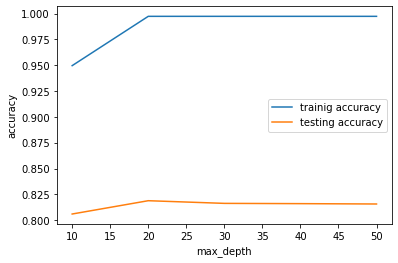

In [33]:
max_depth1 = [10,20,30,40,50]
n_estimators1 = [80,75,70,65,60]
plt.plot(max_depth1,train5,label="trainig accuracy")
plt.plot(max_depth1,test5,label="testing accuracy")
plt.legend()
plt.xlabel('max_depth')
plt.ylabel('accuracy')

plt.show()

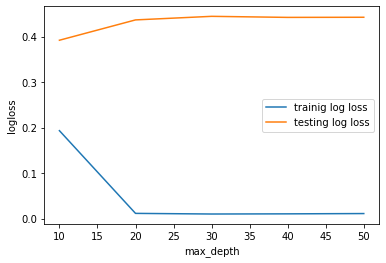

In [34]:
max_depth1 = [10,20,30,40,50]
n_estimators1 = [80,75,70,65,60]
plt.plot(max_depth1,log_train5,label="trainig log loss")
plt.plot(max_depth1,log_test5,label="testing log loss")
plt.legend()
plt.xlabel('max_depth')
plt.ylabel('logloss')

plt.show()

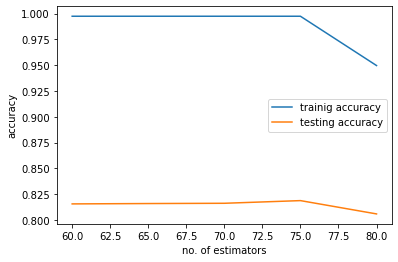

In [35]:
plt.plot(n_estimators1,train5,label="trainig accuracy")
plt.plot(n_estimators1,test5,label="testing accuracy")
plt.legend()
plt.xlabel('no. of estimators')
plt.ylabel('accuracy')

plt.show()

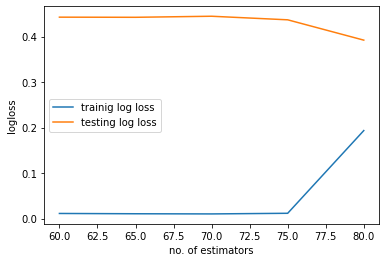

In [36]:
plt.plot(n_estimators1,log_train5,label="trainig log loss")
plt.plot(n_estimators1,log_test5,label="testing log loss")
plt.legend()
plt.xlabel('no. of estimators')
plt.ylabel('logloss')

plt.show()

### Logistic Regression

In [206]:
# joblib.dump(clf2,'log')
clf2 = joblib.load('log')

['log']

In [220]:
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.metrics import accuracy_score

clf2 = LogisticRegression(max_iter=600,C=0.3)
clf2.fit(X_train,Y_train)
pred_train2 = clf2.predict(X_train)
pred2 = clf2.predict(X_test)



In [221]:
print("training accuracy : ",accuracy_score(Y_train,pred_train2))
print("test accuracy : ",accuracy_score(Y_test,pred2))
pred_train_prob2 = clf2.predict_proba(X_train)
pred_prob2 = clf2.predict_proba(X_test)
print("log loss of train set : ",log_loss(Y_train,pred_train_prob2))
print("log loss of test set : ",log_loss(Y_test,pred_prob2))

training accuracy :  0.7309604491825175
test accuracy :  0.7300699992579583
log loss of train set :  0.5188441765221645
log loss of test set :  0.5209638364737382


In [63]:
print(classification_report(Y_train,pred_train2))

              precision    recall  f1-score   support

           0       0.76      0.84      0.80    178667
           1       0.66      0.55      0.60    104336

    accuracy                           0.73    283003
   macro avg       0.71      0.69      0.70    283003
weighted avg       0.72      0.73      0.72    283003



In [64]:
print(classification_report(Y_test,pred2))

              precision    recall  f1-score   support

           0       0.76      0.84      0.80     76360
           1       0.66      0.55      0.60     44927

    accuracy                           0.73    121287
   macro avg       0.71      0.69      0.70    121287
weighted avg       0.72      0.73      0.72    121287



In [37]:
from sklearn.linear_model import LogisticRegression,SGDClassifier
start = time.time()
max_iter1 = [100,200,250,300,600]
c_val = [1,0.8,0.7,0.5,0.3]
train10 = []
test10 = []
clf15 = []
for i in range(5):
    clf2 = LogisticRegression(max_iter = max_iter1[i],C=c_val[i])
    clf2.fit(X_train,Y_train)
    pred_train2 = clf2.predict(X_train)
    pred2 = clf2.predict(X_test)
    clf15.append(clf2)
    train10.append(accuracy_score(Y_train,pred_train2))
    test10.append(accuracy_score(Y_test,pred2))
    print(time.time()-start)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


13.956161975860596


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


39.95621085166931


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


69.0603666305542


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


101.77708530426025
157.75459551811218


In [38]:
train_acc1 = [accuracy_score(Y_train,clf2.predict(X_train)) for clf2 in clf15]
test_acc1 = [accuracy_score(Y_test,clf2.predict(X_test)) for clf2 in clf15]
train_acc_prob1 = [log_loss(Y_train,clf2.predict_proba(X_train)) for clf2 in clf15]
test_acc_prob1 = [log_loss(Y_test,clf2.predict_proba(X_test)) for clf2 in clf15]

print(train_acc1)
print(test_acc1)
print(train_acc_prob1)
print(test_acc_prob1)

[0.7302926117390982, 0.7308226414560977, 0.7307307696384844, 0.7308544432391176, 0.7309604491825175]
[0.7295093456017545, 0.7296247742956788, 0.7295258354151722, 0.7299215909371986, 0.7300699992579583]
[0.519647753682981, 0.5189835085168282, 0.5189559709409871, 0.5188443720034696, 0.5188441765221645]
[0.521739422220199, 0.5212183149641544, 0.5211915831282148, 0.5210219234737454, 0.5209638364737382]


In [39]:
log = pd.DataFrame()
log['max_iter'] = max_iter1
log['C'] = c_val
log['train accuracy'] = train_acc1
log['test accuracy'] = test_acc1
log['train log loss'] = train_acc_prob1
log['test log loss'] = test_acc_prob1
log

,max_iter,C,train accuracy,test accuracy,train log loss,test log loss
0,100,1.0,0.730293,0.729509,0.519648,0.521739
1,200,0.8,0.730823,0.729625,0.518984,0.521218
2,250,0.7,0.730731,0.729526,0.518956,0.521192
3,300,0.5,0.730854,0.729922,0.518844,0.521022
4,600,0.3,0.730960,0.730070,0.518844,0.520964


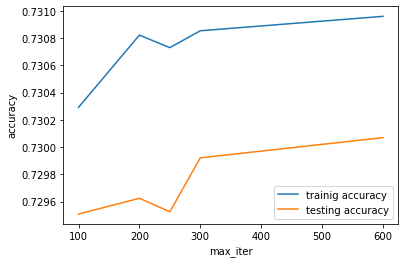

In [40]:
plt.plot(max_iter1,train_acc1,label="trainig accuracy")
plt.plot(max_iter1,test_acc1,label="testing accuracy")
plt.legend()
plt.xlabel('max_iter')
plt.ylabel('accuracy')

plt.show()

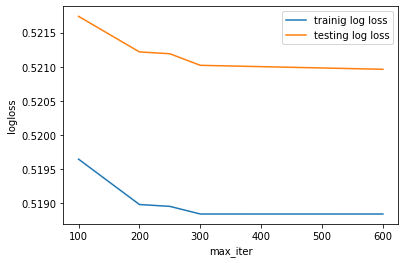

In [41]:
plt.plot(max_iter1,train_acc_prob1,label="trainig log loss")
plt.plot(max_iter1,test_acc_prob1,label="testing log loss")
plt.legend()
plt.xlabel('max_iter')
plt.ylabel('logloss')
plt.show()

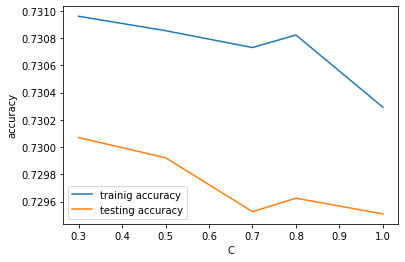

In [42]:
plt.plot(c_val,train_acc1,label="trainig accuracy")
plt.plot(c_val,test_acc1,label="testing accuracy")
plt.legend()
plt.xlabel('C')
plt.ylabel('accuracy')

plt.show()

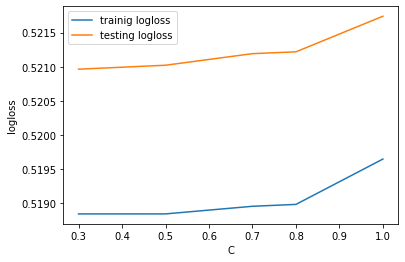

In [43]:
plt.plot(c_val,train_acc_prob1,label="trainig logloss")
plt.plot(c_val,test_acc_prob1,label="testing logloss")
plt.legend()
plt.xlabel('C')
plt.ylabel('logloss')

plt.show()

In [113]:
clf2

LogisticRegression(C=0.3, max_iter=600)

No handles with labels found to put in legend.


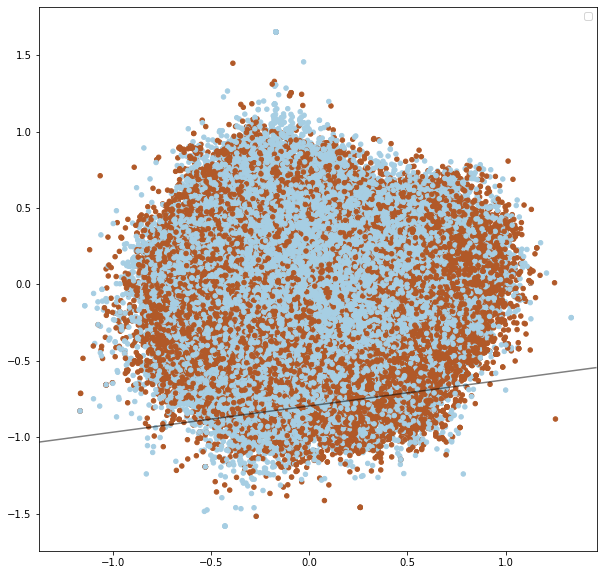

In [115]:
clf2.fit(xtrain1,Y_train)
plot_dec_boundary(clf2,xtrain1)

### Random Forest

In [15]:
from sklearn.ensemble import RandomForestClassifier
import time
start = time.time()
max_depth1 = [10,20,30,40,50]
n_estimators1 = [80,75,70,65,60,55]
train6 = []
test6 = []
clf6 = []
for i in range(5):
    clf3 = RandomForestClassifier(n_estimators=n_estimators1[i],max_depth=max_depth1[i])

    clf3.fit(X_train,Y_train)
    pred_train3 = clf3.predict(X_train)
    pred3 = clf3.predict(X_test)
    
    clf6.append(clf3)
    train6.append(accuracy_score(Y_train,pred_train3))
    test6.append(accuracy_score(Y_test,pred3))
    print(time.time()-start)

In [44]:
import joblib
# joblib.dump(clf6,'random_forset')
clf6 = joblib.load('random_forset')

In [45]:
train6 = [accuracy_score(Y_train,clf2.predict(X_train)) for clf2 in clf6]
test6 = [accuracy_score(Y_test,clf2.predict(X_test)) for clf2 in clf6]
log_train6 = [log_loss(Y_train,clf2.predict_proba(X_train)) for clf2 in clf6]
log_test6 = [log_loss(Y_test,clf2.predict_proba(X_test)) for clf2 in clf6]

print(train6)
print(test6)
print(log_train6)
print(log_test6)

[0.7722108952908626, 0.939156122019908, 0.9893923385971174, 0.9955972198174577, 0.9969010929212765]
[0.7503607146685135, 0.7975298259500194, 0.8089160421149835, 0.8101280434011889, 0.8097405327858715]
[0.48033667066213775, 0.2579661734602477, 0.14660128979878528, 0.12373363523122458, 0.12046052812858174]
[0.49563501900854307, 0.41934339014727967, 0.40333017717887254, 0.4047990836798513, 0.4087278426855853]


In [47]:
max_depth1 = [10,20,30,40,50]
n_estimators1 = [80,75,70,65,60]
rf = pd.DataFrame()
rf['max_depth'] = max_depth1
rf['n_estimators'] = n_estimators1
rf['train accuracy'] = train6
rf['test accuracy'] = test6
rf['train log loss'] = log_train6
rf['test log loss'] = log_test6
rf

,max_depth,n_estimators,train accuracy,test accuracy,train log loss,test log loss
0,10,80,0.772211,0.750361,0.480337,0.495635
1,20,75,0.939156,0.797530,0.257966,0.419343
2,30,70,0.989392,0.808916,0.146601,0.403330
3,40,65,0.995597,0.810128,0.123734,0.404799
4,50,60,0.996901,0.809741,0.120461,0.408728


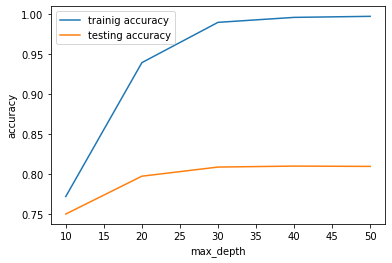

In [48]:
plt.plot(max_depth1,train6,label="trainig accuracy")
plt.plot(max_depth1,test6,label="testing accuracy")
plt.legend()
plt.xlabel('max_depth')
plt.ylabel('accuracy')

plt.show()

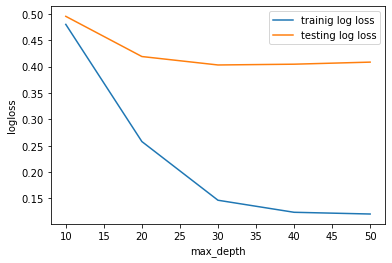

In [49]:
plt.plot(max_depth1,log_train6,label="trainig log loss")
plt.plot(max_depth1,log_test6,label="testing log loss")
plt.legend()
plt.xlabel('max_depth')
plt.ylabel('logloss')
plt.show()

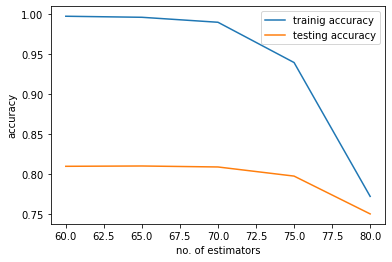

In [50]:
plt.plot(n_estimators1,train6,label="trainig accuracy")
plt.plot(n_estimators1,test6,label="testing accuracy")
plt.legend()
plt.xlabel('no. of estimators')
plt.ylabel('accuracy')

plt.show()

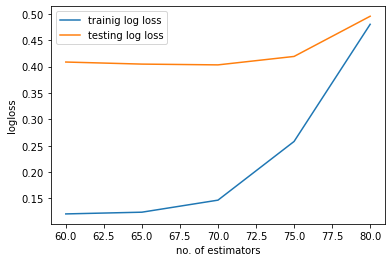

In [51]:
plt.plot(n_estimators1,log_train6,label="trainig log loss")
plt.plot(n_estimators1,log_test6,label="testing log loss")
plt.legend()
plt.xlabel('no. of estimators')
plt.ylabel('logloss')
plt.show()

In [222]:
# joblib.dump(clf3,'rf')
clf31 = joblib.load('rf')

In [224]:
# clf31 = RandomForestClassifier(n_estimators=55,max_depth=50)

# clf31.fit(X_train,Y_train)
pred_train3 = clf31.predict(X_train)
pred3 = clf31.predict(X_test)

# clf6.append(clf3)


In [227]:
print("training accuracy : ",accuracy_score(Y_train,pred_train3))
print("test accuracy : ",accuracy_score(Y_test,pred3))
pred_train_prob3 = clf31.predict_proba(X_train)
pred_prob3 = clf31.predict_proba(X_test)
print("log loss of train set : ",log_loss(Y_train,pred_train_prob3))
print("log loss of test set : ",log_loss(Y_test,pred_prob3))

training accuracy :  0.9968657576068098
test accuracy :  0.8088913073948568
log loss of train set :  0.12101719846345803
log loss of test set :  0.4096336173201389


In [121]:
print(classification_report(Y_train,pred_train3))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    178667
           1       1.00      1.00      1.00    104336

    accuracy                           1.00    283003
   macro avg       1.00      1.00      1.00    283003
weighted avg       1.00      1.00      1.00    283003



In [122]:
print(classification_report(Y_test,pred3))

              precision    recall  f1-score   support

           0       0.82      0.89      0.85     76360
           1       0.79      0.67      0.72     44927

    accuracy                           0.81    121287
   macro avg       0.80      0.78      0.79    121287
weighted avg       0.81      0.81      0.81    121287



### SVC (Linear)

In [228]:
from sklearn.linear_model import LogisticRegression,SGDClassifier
clf3 = SGDClassifier(loss='hinge')
clf3.fit(X_train,Y_train)

pred_train3 = clf3.predict(X_train)
pred3 = clf3.predict(X_test)



In [229]:
print("training accuracy : ",accuracy_score(Y_train,pred_train3))
print("test accuracy : ",accuracy_score(Y_test,pred3))
from sklearn.calibration import CalibratedClassifierCV
clf10 = CalibratedClassifierCV(base_estimator=clf3, cv="prefit")
clf10.fit(X_train,Y_train)
pred_train_prob3 = clf10.predict_proba(X_train)
pred_prob3 = clf10.predict_proba(X_test)
print("log loss of train set : ",log_loss(Y_train,pred_train_prob3))
print("log loss of test set : ",log_loss(Y_test,pred_prob3))

training accuracy :  0.7359391949908658
test accuracy :  0.7347448613618937
log loss of train set :  0.5212037097570729
log loss of test set :  0.5232963870799451


In [79]:
print(classification_report(Y_train,pred_train3))

              precision    recall  f1-score   support

           0       0.75      0.86      0.80    178667
           1       0.68      0.52      0.59    104336

    accuracy                           0.73    283003
   macro avg       0.72      0.69      0.70    283003
weighted avg       0.73      0.73      0.72    283003



In [80]:
print(classification_report(Y_test,pred3))

              precision    recall  f1-score   support

           0       0.75      0.85      0.80     76360
           1       0.68      0.53      0.59     44927

    accuracy                           0.73    121287
   macro avg       0.72      0.69      0.70    121287
weighted avg       0.73      0.73      0.72    121287



In [89]:
# clf3 = SGDClassifier(loss='hinge')
clf3.fit(xtrain1,Y_train)

SGDClassifier()

No handles with labels found to put in legend.


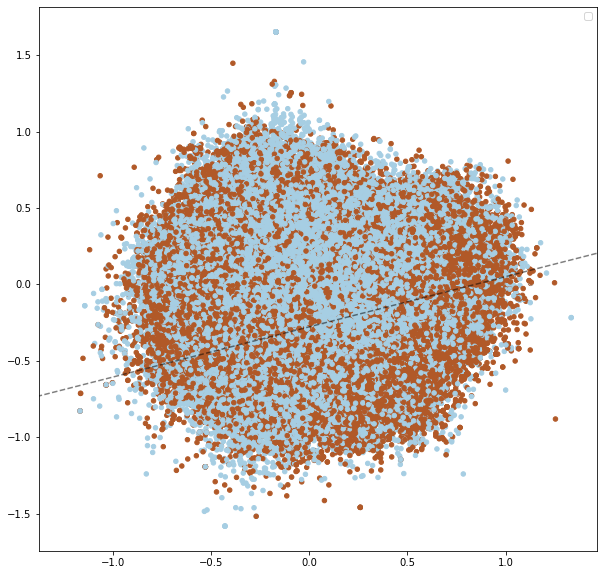

In [165]:
clf3.fit(xtrain1,Y_train)
plot_dec_boundary_svc(clf3,xtrain1)

In [65]:
# joblib.dump(x_rbf_train,'x_rbf_train')
# joblib.dump(x_rbf_test,'x_rbf_test')
x_rbf_train = joblib.load('x_rbf_train')
x_rbf_test = joblib.load('x_rbf_test')



In [64]:
# joblib.dump(clf4,'rbf')
clf4 = joblib.load('rbf')

### SVC (RBF)

In [67]:
from sklearn.kernel_approximation import RBFSampler

# rbf = RBFSampler(random_state=0,n_components=2500)
# x_rbf_train = rbf.fit_transform(X_train)
# x_rbf_test = rbf.fit_transform(X_test)

# clf4 = SGDClassifier()
# clf4.fit(x_rbf_train,Y_train)

pred_train4 = clf4.predict(x_rbf_train)
pred4 = clf4.predict(x_rbf_test)



In [68]:
print("training accuracy : ",accuracy_score(Y_train,pred_train4))
print("test accuracy : ",accuracy_score(Y_test,pred4))
clf11 = CalibratedClassifierCV(base_estimator=clf4, cv="prefit")
clf11.fit(x_rbf_train,Y_train)
pred_train_prob3 = clf11.predict_proba(x_rbf_train)
pred_prob3 = clf11.predict_proba(x_rbf_test)
print("log loss of train set : ",log_loss(Y_train,pred_train_prob3))
print("log loss of test set : ",log_loss(Y_test,pred_prob3))

training accuracy :  0.7622039342339127
test accuracy :  0.7592157444738513
log loss of train set :  0.47568084105142333
log loss of test set :  0.4798682336370127


In [69]:
print(classification_report(Y_train,pred_train4))

              precision    recall  f1-score   support

           0       0.79      0.85      0.82    178667
           1       0.70      0.62      0.66    104336

    accuracy                           0.76    283003
   macro avg       0.75      0.73      0.74    283003
weighted avg       0.76      0.76      0.76    283003



In [70]:
print(classification_report(Y_test,pred4))

              precision    recall  f1-score   support

           0       0.79      0.84      0.82     76360
           1       0.70      0.62      0.65     44927

    accuracy                           0.76    121287
   macro avg       0.74      0.73      0.73    121287
weighted avg       0.76      0.76      0.76    121287



In [109]:
rbf1 = RBFSampler(random_state=0)
x_pc_rbd_train = rbf1.fit_transform(xtrain1)
x_pc_rbd_test = rbf1.fit_transform(xtest1)
x_pc_rbd_train = p.fit_transform(x_pc_rbd_train)
x_pc_rbd_test = p.fit_transform(x_pc_rbd_test)
clf20 = SGDClassifier()
clf20.fit(x_pc_rbd_train,Y_train)

SGDClassifier()

In [110]:
x_pc_rbd_train.shape

(283003, 2)

No handles with labels found to put in legend.


(2500, 2)


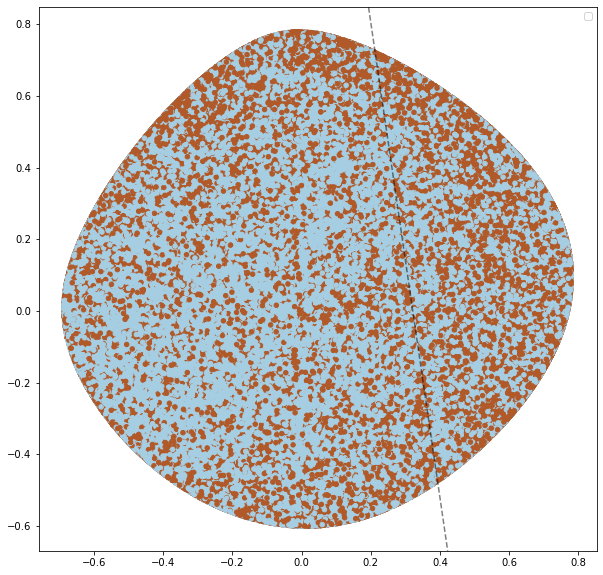

In [111]:
plot_dec_boundary_svc(clf20,x_pc_rbd_train)

In [98]:
xtest1.shape

(121287, 2)

In [26]:
Y1 = Y_train.values
Y1.shape

(283003,)

### MLP

In [52]:
from sklearn.neural_network import MLPClassifier
hl = [400,300,250,200,100]
max_iter6 = [200,250,300,350,400,500]
mlp=[]
for i in range(5):
    start = time.time()
    clf12 = MLPClassifier(random_state=0,hidden_layer_sizes=hl[i],max_iter=max_iter6[i])
    clf12.fit(X_train, Y_train)
    mlp.append(clf12)
    print(time.time()-start)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1093.0562596321106
309.3503432273865
410.97127771377563
133.25793528556824
95.85684704780579


In [53]:
train9 = [accuracy_score(Y_train,clf2.predict(X_train)) for clf2 in mlp]
test9 = [accuracy_score(Y_test,clf2.predict(X_test)) for clf2 in mlp]
log_train9 = [log_loss(Y_train,clf2.predict_proba(X_train)) for clf2 in mlp]
log_test9 = [log_loss(Y_test,clf2.predict_proba(X_test)) for clf2 in mlp]

print(train9)
print(test9)
print(log_train9)
print(log_test9)

[0.7559531171047656, 0.7631085182842585, 0.7637162856930845, 0.7562464002148387, 0.7598364681646484]
[0.7527929621476332, 0.7606503582411965, 0.7613923998449957, 0.7547305152242202, 0.758745784791445]
[0.46470592584362885, 0.4603283665730224, 0.46168611704890056, 0.47172401073563414, 0.4646138615716466]
[0.4700078393248656, 0.4642572676730664, 0.4652087438786359, 0.4734318199665586, 0.4677406495326342]


In [55]:
hl = [400,300,250,200,100]
max_iter6 = [200,250,300,350,400]
mlp2 = pd.DataFrame()
mlp2['hidden layers'] = hl
mlp2['max_iter'] = max_iter6
mlp2['train accuracy'] = train9
mlp2['test accuracy'] = test9
mlp2['train log loss'] = log_train9
mlp2['test log loss'] = log_test9
mlp2

,hidden layers,max_iter,train accuracy,test accuracy,train log loss,test log loss
0,400,200,0.755953,0.752793,0.464706,0.470008
1,300,250,0.763109,0.760650,0.460328,0.464257
2,250,300,0.763716,0.761392,0.461686,0.465209
3,200,350,0.756246,0.754731,0.471724,0.473432
4,100,400,0.759836,0.758746,0.464614,0.467741


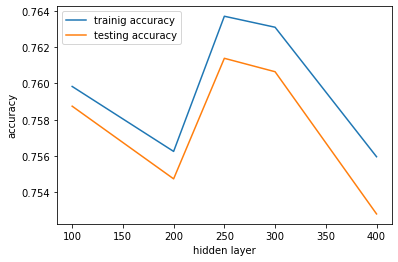

In [56]:
plt.plot(hl,train9,label="trainig accuracy")
plt.plot(hl,test9,label="testing accuracy")
plt.legend()
plt.xlabel('hidden layer')
plt.ylabel('accuracy')

plt.show()

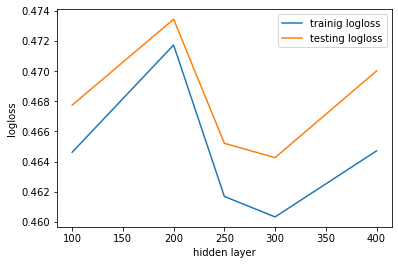

In [57]:
plt.plot(hl,log_train9,label="trainig logloss")
plt.plot(hl,log_test9,label="testing logloss")
plt.legend()
plt.xlabel('hidden layer')
plt.ylabel('logloss')

plt.show()

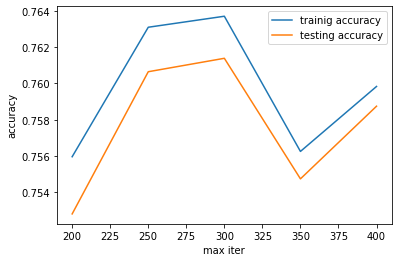

In [58]:
plt.plot(max_iter6,train9,label="trainig accuracy")
plt.plot(max_iter6,test9,label="testing accuracy")
plt.legend()
plt.xlabel('max iter')
plt.ylabel('accuracy')

plt.show()

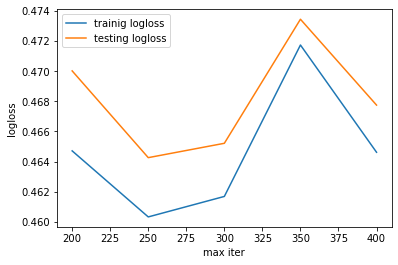

In [59]:
plt.plot(max_iter6,log_train9,label="trainig logloss")
plt.plot(max_iter6,log_test9,label="testing logloss")
plt.legend()
plt.xlabel('max iter')
plt.ylabel('logloss')

plt.show()

In [60]:
from sklearn.neural_network import MLPClassifier
clf12 = MLPClassifier(random_state=0,hidden_layer_sizes=300,max_iter=250)
clf12.fit(X_train, Y_train)

pred_train3 = clf12.predict(X_train)
pred3 = clf12.predict(X_test)



In [61]:
print("training accuracy : ",accuracy_score(Y_train,pred_train3))
print("test accuracy : ",accuracy_score(Y_test,pred3))
from sklearn.calibration import CalibratedClassifierCV
clf13 = CalibratedClassifierCV(base_estimator=clf12, cv="prefit")
clf13.fit(X_train,Y_train)
pred_train_prob3 = clf13.predict_proba(X_train)
pred_prob3 = clf13.predict_proba(X_test)
print("log loss of train set : ",log_loss(Y_train,pred_train_prob3))
print("log loss of test set : ",log_loss(Y_test,pred_prob3))

training accuracy :  0.7631085182842585
test accuracy :  0.7606503582411965
log loss of train set :  0.46937022039449977
log loss of test set :  0.4733394170818621


In [62]:
print(classification_report(Y_train,pred_train3))

              precision    recall  f1-score   support

           0       0.78      0.87      0.82    178667
           1       0.73      0.57      0.64    104336

    accuracy                           0.76    283003
   macro avg       0.75      0.72      0.73    283003
weighted avg       0.76      0.76      0.76    283003



In [63]:
print(classification_report(Y_test,pred3))

              precision    recall  f1-score   support

           0       0.78      0.87      0.82     76360
           1       0.72      0.57      0.64     44927

    accuracy                           0.76    121287
   macro avg       0.75      0.72      0.73    121287
weighted avg       0.76      0.76      0.75    121287



In [195]:
from matplotlib.colors import ListedColormap
def plot_dec(s,clf12,xtrain1,xtest1):
    step = 0.02
    figure = plt.figure(figsize=(25,10))
    xl, xh = xtrain1[:, 0].min() - 0.5, xtrain1[:, 0].max() + 0.5
    yl, yh = xtrain1[:, 1].min() - 0.5, xtrain1[:, 1].max() + 0.5
    xc, yc = np.meshgrid(np.arange(xl, xh, step), np.arange(yl, yh, step))
    name=s
    color = ListedColormap(["#FF0000", "#0000FF"])
    
    fig,ax = plt.subplots()
    ax.scatter(xtrain1[:, 0], xtrain1[:, 1], c=Y_train, cmap=color, edgecolors="k")
    ax.set_xlim(xc.min(), xc.max())
    ax.set_ylim(yc.min(), yc.max())
    ax.set_xticks(())
    ax.set_yticks(())
    clf12.fit(xtrain1, Y_train)
    score = clf12.score(xtest1, Y_test)
    
    if hasattr(clf12, "decision_function"):
        A = clf12.decision_function(np.c_[xc.ravel(), yc.ravel()])
    else:
        A = clf12.predict_proba(np.c_[xc.ravel(), yc.ravel()])[:, 1]
        
    A = A.reshape(xc.shape)
    cm = plt.cm.RdBu
    ax.contourf(xc, yc, A, cmap=cm, alpha=0.8)
    
    ax.scatter(
        xtrain1[:, 0], xtrain1[:, 1], c=Y_train, cmap=color, edgecolors="k"
    )
#     # Plot the testing points
#     ax.scatter(
#         xtest1[:, 0],
#         xtest1[:, 1],
#         c=Y_test,
#         cmap=cm_bright,
#         edgecolors="k",
#         alpha=0.6,
#     )
    
    ax.set_xlim(xc.min(), xc.max())
    ax.set_ylim(yc.min(), yc.max())
    ax.set_xticks(())
    ax.set_yticks(())
    
    ax.set_title(name)
    plt.tight_layout()
    plt.show()

### Decision boundary

<Figure size 1800x720 with 0 Axes>

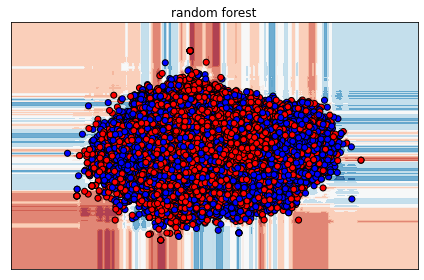

In [201]:
plot_dec("random forest",clf31,xtrain1,xtest1)

<Figure size 1800x720 with 0 Axes>

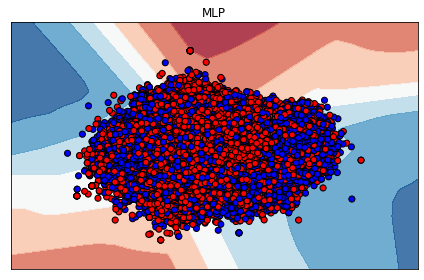

In [245]:
plot_dec("MLP",clf12,xtrain1,xtest1)

<Figure size 1800x720 with 0 Axes>

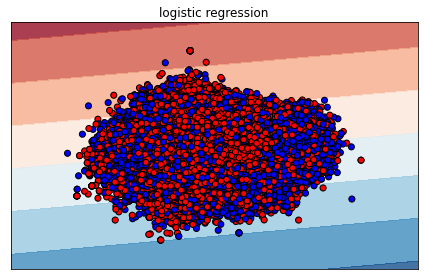

In [199]:
plot_dec("logistic regression",clf2,xtrain1,xtest1)

<Figure size 1800x720 with 0 Axes>

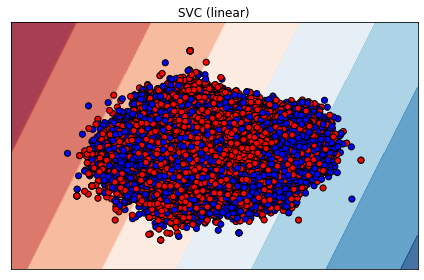

In [198]:
plot_dec("SVC (linear)",clf3,xtrain1,xtest1)

[15:24:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<Figure size 1800x720 with 0 Axes>

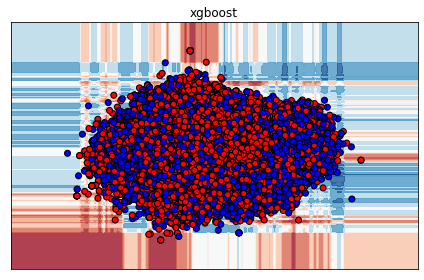

In [197]:
plot_dec("xgboost",clf1,xtrain1,xtest1)

<Figure size 1800x720 with 0 Axes>

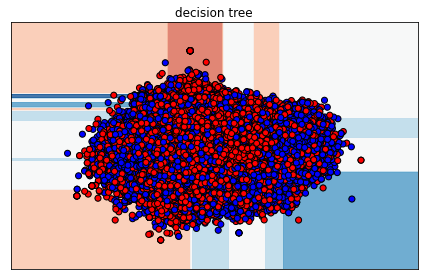

In [204]:
plot_dec("decision tree",clf,xtrain1,xtest1)

<Figure size 1800x720 with 0 Axes>

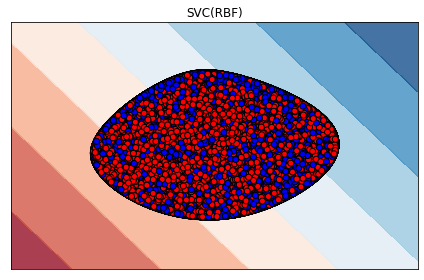

In [196]:
plot_dec("SVC(RBF)",clf20,x_pc_rbd_train,x_pc_rbd_test)

### LSTM

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

!unzip /kaggle/input/quora-question-pairs/train.csv.zip

import random
import pandas as pd
from keras.models import Sequential
from keras.preprocessing import sequence
import numpy as np
import keras
import tensorflow as tf
from tensorflow.keras import layers
from tqdm import tqdm
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt


data = pd.read_csv('train.csv')

data = data.dropna()
data = data.reset_index(drop=True)
data.shape[0]

def pre_processing(data):
    data['question1'] = data['question1'].str.lower()
    data['question2'] = data['question2'].str.lower()
    #Removing tags present in review
    data['question1'] = data['question1'].str.replace('<.*?>','')
    data['question2'] = data['question2'].str.replace('<.*?>','')
    #Removing URLs present in review
    data['question1'] = data['question1'].str.replace(r'http\S+','')
    data['question2'] = data['question2'].str.replace(r'http\S+','')
    #Removing punctuations
    data['question1'] = data['question1'].str.replace('[^\w\s]','')
    data['question2'] = data['question2'].str.replace('[^\w\s]','')
    return data

data = pre_processing(data)

# Shuffle the data
seed = 1337
data = data.sample(frac = 1, random_state=seed)

# Extract a training & validation split
validation_split = 0.2
num_validation_samples = int(validation_split * len(data))
train_data = data[:-num_validation_samples]
val_data = data[-num_validation_samples:]

train_question1 = train_data['question1']
train_question2 = train_data['question2']
train_label = train_data['is_duplicate']

val_question1 = val_data['question1']
val_question2 = val_data['question2']
val_label = val_data['is_duplicate']

all_train_sentence = pd.concat([train_question1, train_question2], ignore_index=True)
all_train_sentence.shape[0]

vectorizer = layers.TextVectorization(max_tokens=50000, output_sequence_length=50)
text_ds = tf.data.Dataset.from_tensor_slices(all_train_sentence).batch(128)
vectorizer.adapt(text_ds)

voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))
len(voc)

path_to_glove_file = "/kaggle/input/glove6b/glove.6B.100d.txt"
embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

embedding_layer = layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

input1 = keras.Input(shape=(None,), dtype="string")
input2 = keras.Input(shape=(None,), dtype="string")

int_sequences_input1 = vectorizer(input1)
int_sequences_input2 = vectorizer(input2)

embedded_sequence1 = embedding_layer(int_sequences_input1)
embedded_sequence2 = embedding_layer(int_sequences_input2)

shared_lstm_1 = layers.LSTM(100) 
# shared_lstm_1 = layers.LSTM(100, return_sequences=True) 
# shared_lstm_2 = layers.LSTM(50)

x1 = shared_lstm_1(embedded_sequence1)
# x1 = shared_lstm_2(x1)

x2 = shared_lstm_1(embedded_sequence2)
# x2 = shared_lstm_2(x2)

x = layers.Concatenate(axis=-1)([x1,x2])
x = layers.Dropout(0.2)(x)
x = layers.BatchNormalization()(x)

dense_layer1 = layers.Dense(50, activation="relu")
x = dense_layer1(x)
x = layers.Dropout(0.2)(x)
x = layers.BatchNormalization()(x)

preds = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model([input1, input2], preds)
model.summary()

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.compile(
    loss="binary_crossentropy", optimizer="rmsprop", metrics=["acc", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)
history = model.fit([train_question1,train_question2], train_label, 
                    batch_size=128, epochs=20, callbacks=[callback],
                    validation_data=([val_question1, val_question2], val_label))

accuracy = history.history["acc"]
loss = history.history["loss"]

val_accuracy = history.history["val_acc"]
val_loss = history.history["val_loss"]

#plot 
plt.plot(accuracy,'g',label='training accuracy')
plt.plot(val_accuracy, 'r', label='validation accuracy')
plt.legend()
plt.show()


plt.plot(loss,'g',label='training loss')
plt.plot(val_loss, 'r', label='validation loss')
plt.legend()
plt.show()

model.save('lstm_siemese_v5')

!zip -r lstm_siemese.zip lstm_siemese

test_data = pd.read_csv('/kaggle/input/quora-question-pairs/test.csv')
test_data = test_data.fillna('')

batches = list(range(0,2345796, 234580))
batches.append(2345796)
batches

#takes about 35 mins
probabilities = np.array([])
for i in tqdm(range(len(batches) - 1)):
    start = batches[i]
    end = batches[i+1]
    test_question1 = test_data['question1'][start:end]
    test_question2 = test_data['question2'][start:end]
    probs = model.predict([test_question1, test_question2])
    probs = probs.reshape(-1)
    probabilities = np.concatenate([probabilities, probs])

output = test_data[['test_id']]
output.shape
output['is_duplicate'] = probabilities

output.to_csv('lstm_siemese_v5.csv',index=False)